In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import datetime
from sklearn.metrics import roc_auc_score
import seaborn as sns
sns.set_style()
import pandas as pd
%matplotlib inline

In [27]:
datasplit_df = pd.read_csv('data/train_test_valid_id_split.csv')[['videoid','dataset']]
datasplit_df['videoid'] = datasplit_df['videoid'].apply(lambda x: int(x))
alldata_processed = alldata_processed.merge(right=datasplit_df,on=['videoid'],how='inner')

In [28]:
alldata_processed = pd.read_csv("./data/annotations/alldata_processed.csv")
datasplit_df = pd.read_csv('data/train_test_valid_id_split.csv')[['videoid','dataset']]
datasplit_df['videoid'] = datasplit_df['videoid'].apply(lambda x: int(x))
alldata_processed = alldata_processed.merge(right=datasplit_df,on=['videoid'],how='inner')
alldata_processed['const'] = 1

In [31]:
#age is truncated at 20 years because the relationship between age and SEMLS after 20 years is non-linear and 
#noisier
alldata_processed['age_truncated'] = np.clip(alldata_processed['age'],0,20) 

In [32]:
#interpolate missing mass and height: there are only 6 instances where these values are missing
#interpolate missing mass
df_interp = alldata_processed[alldata_processed['dataset'] == 'train'].copy()
X = df_interp[["age_truncated","const"]].values
y = df_interp["mass"].values.reshape(-1,1)
lm = OLS(y,X,missing='drop').fit()

alldata_processed["predicted_mass"] = lm.predict(alldata_processed[["age_truncated","const"]].values)
alldata_processed["mass_interpolated"] = np.where(alldata_processed["mass"].isnull(),alldata_processed["predicted_mass"],
                                                 alldata_processed["mass"])

alldata_processed["log_interpolated_mass"] = np.log(alldata_processed["mass_interpolated"])
#interpolate missing height using log(mass)
df_interp = alldata_processed[alldata_processed['dataset'] == 'train'].copy()
X = df_interp[["log_interpolated_mass","const"]].values
y = df_interp["height"].values.reshape(-1,1)
lm = OLS(y,X,missing='drop').fit()

alldata_processed["predicted_height"] = lm.predict(alldata_processed[["log_interpolated_mass","const"]].values)

alldata_processed["height_interpolated"] = np.where(alldata_processed["height"].isnull(),alldata_processed["predicted_height"],
                                                 alldata_processed["height"])

In [33]:
#bucket data to make graphs
alldata_processed['mass_buckets'] =\
    np.clip(np.floor(alldata_processed['mass_interpolated']/5)*5,1,80)

alldata_processed['height_buckets'] =\
    np.clip(np.floor(alldata_processed['height_interpolated']/10)*10,90,180)
    
alldata_processed['age_buckets'] =\
    np.clip(np.floor(alldata_processed['age']),0,20)

/home/bryan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


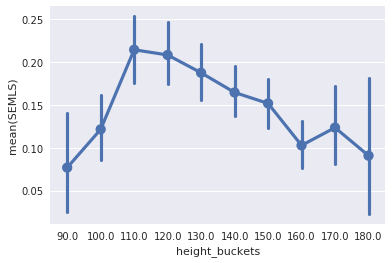

In [34]:
sns.pointplot(x='height_buckets',y='SEMLS',data=alldata_processed[alldata_processed['dataset'] == 'train'])

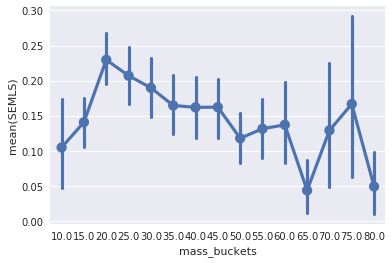

In [35]:
sns.pointplot(x='mass_buckets',y='SEMLS',data=alldata_processed[alldata_processed['dataset'] == 'train'])

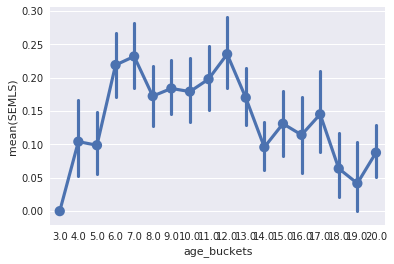

In [36]:
sns.pointplot(x='age_buckets',y='SEMLS',data=alldata_processed[alldata_processed['dataset'] == 'train'])

In [37]:
alldata_processed['mass_interpolated2'] = np.square(alldata_processed['mass_interpolated'])/100
alldata_processed['age_truncated2'] = np.square(alldata_processed['age_truncated'])/100
alldata_processed['height_interpolated2'] = np.square(alldata_processed['height_interpolated'])/100

In [38]:
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         "isPostSurgGaitVisit","const"]

X_train = alldata_processed[alldata_processed['dataset'] == 'train'][Xcols]
y_train = alldata_processed[alldata_processed['dataset'] == 'train']["SEMLS"]
X = alldata_processed[Xcols].values
y = alldata_processed["SEMLS"].values

lm = Logit(y_train,X_train).fit()


alldata_processed['predicted_SEMLS'] = lm.predict(X)

Optimization terminated successfully.
         Current function value: 0.434632
         Iterations 7


In [39]:
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.019     
Dependent Variable:  SEMLS             AIC:               3115.7943 
Date:                2018-09-25 01:22  BIC:               3165.2279 
No. Observations:    3566              Log-Likelihood:    -1549.9   
Df Model:            7                 LL-Null:           -1580.1   
Df Residuals:        3558              LLR p-value:       1.2046e-10
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
mass_interpolated    -0.0099   0.0189 -0.5244 0.6000 -0.0469  0.0271
mass_interpolated2    0.0010   0.0170  0.0613 0.9511 -0.0323  0.0344
age_truncated2       -1.5842   0.3919 -4.0425 0.0001 -2.3522 -0.8161
age_truncated         0.3992   0.1088  3.6684 0.0002  0.1859  0.6125
height_interpolated   0.0059   0.0402  0.1462 0.8837 -0.0728  0.0846
height_interpolated2 -0.0050   0.0138 -0.3607 0.7183 -0.0321  0.0221
isPostSurgGaitVisit  -0.2743   0.0926 -2.9605 0.0031 -0.4558 -0.0927
const                -3.2030   2.4321 -1.3170 0.1878 -7.9698  1.5638
====================================================================

"""

In [40]:
def compute_deviance_residual(y,predicted_prob):
    return np.where(y==1,np.sqrt(-2.0*np.log(predicted_prob)),
                                 -np.sqrt(-2.0*np.log(1-predicted_prob)))

In [41]:
roc_auc_score(alldata_processed[alldata_processed['dataset'] == 'train']['SEMLS'],
              alldata_processed[alldata_processed['dataset'] == 'train']['predicted_SEMLS'])

0.59979971790275288

In [42]:
roc_auc_score(alldata_processed[alldata_processed['dataset'] == 'validation']['SEMLS'],
              alldata_processed[alldata_processed['dataset'] == 'validation']['predicted_SEMLS'])

0.63266480965645311

In [43]:
alldata_processed['SEMLS_dev_residual'] = compute_deviance_residual(y,
                                                                   lm.predict(X))

In [44]:
alldata_processed.to_csv("./data/annotations/alldata_processed_with_dev_residual.csv",index=False)

In [24]:
alldata_processed['SEMLS_dev_residual'].std()

0.9169791263493673